- Dataet:
    - https://www.kaggle.com/sebastianmantey/nba-free-throws
    - https://data.world/datadavis/nba-salaries

In [39]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

In [2]:
df = pd.read_csv('free_throws/free_throws.csv')
df.head()

,end_result,game,game_id,period,play,player,playoffs,score,season,shot_made,time
0,106 - 114,PHX - LAL,261031013.0,1.0,Andrew Bynum makes free throw 1 of 2,Andrew Bynum,regular,0 - 1,2006 - 2007,1,11:45
1,106 - 114,PHX - LAL,261031013.0,1.0,Andrew Bynum makes free throw 2 of 2,Andrew Bynum,regular,0 - 2,2006 - 2007,1,11:45
2,106 - 114,PHX - LAL,261031013.0,1.0,Andrew Bynum makes free throw 1 of 2,Andrew Bynum,regular,18 - 12,2006 - 2007,1,7:26
3,106 - 114,PHX - LAL,261031013.0,1.0,Andrew Bynum misses free throw 2 of 2,Andrew Bynum,regular,18 - 12,2006 - 2007,0,7:26
4,106 - 114,PHX - LAL,261031013.0,1.0,Shawn Marion makes free throw 1 of 1,Shawn Marion,regular,21 - 12,2006 - 2007,1,7:18


In [3]:
df['time'] = df['time'].apply(lambda x: pd.to_datetime(str(x), format='%M:%S'))
df['minute'] = df['time'].dt.minute
df['second'] = df['time'].dt.second
df['abs_min'] = 12 - df['minute'] + 12 * (df.period -1)
df['abs_time'] = 60 * (df.abs_min - 1) + 60 - df['second']

In [4]:
per_minutes = []

for minute in range(int(np.max(df['abs_min']))):
    per_minutes.append(np.true_divide(len(df[(df['abs_min'] == minute) & (df['shot_made'] == 1)]), 
                                      len(df[(df['abs_min'] == minute)])))

C:\Users\coten\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


First we examine score from free throw over timemm

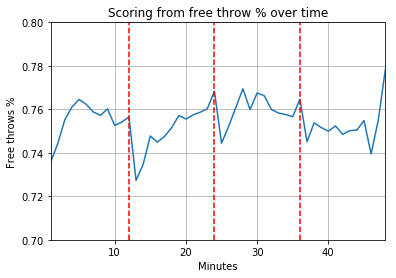

In [5]:
plt.plot(per_minutes)

plt.axvline(12, linestyle = '--', color = 'r')
plt.axvline(24, linestyle = '--', color = 'r')
plt.axvline(36, linestyle = '--', color = 'r')

plt.xlim([1, 48])
plt.ylim([0.7, 0.8])
plt.grid(True)
plt.xlabel('Minutes')
plt.ylabel('Free throws %')
plt.title('Scoring from free throw % over time')

- At the beginning of every period, the number of succes shot drops
- At the end of every period, the percentage goes up

The result mentioned above may caused by the number of shot varies over time. Now, we look at the number of free shot over time

In [6]:
minutes_df = pd.DataFrame()
minutes_df['minutes'] = range(int(np.max(df['abs_min'])))
minutes_df['shots'] = minutes_df['minutes'].apply(lambda x: len(df[df['abs_min'] == x]))

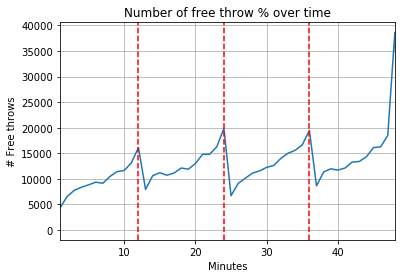

In [7]:
plt.plot(minutes_df['shots'])

plt.axvline(12, linestyle = '--', color = 'r')
plt.axvline(24, linestyle = '--', color = 'r')
plt.axvline(36, linestyle = '--', color = 'r')

plt.xlim([1, 48])
plt.grid(True)
plt.xlabel('Minutes')
plt.ylabel('# Free throws')
plt.title('Number of free throw % over time')

We can see that the number of free throw also drop at the beginning and go up at the end of every quater

Next, we will check second hypothesis: Does it go up thanks to better shooters take the ball ?

In [26]:
last_minutes = [12, 24, 36, 48]
players_df = pd.DataFrame()
players_df['name'] = np.unique(df.player)
players_df['score'] = pd.Series(df.groupby('player')['shot_made'].agg('sum').values)

In [27]:
players_df['last_score'] = players_df['name'].apply(lambda x: len(df[(df['player'] == x) & (df['shot_made'] == 1) 
                                                                     & (df['abs_min'].isin(last_minutes))]))

In [28]:
players_df.sort_values('score', ascending=False, inplace=True)
players_df.set_index('name', inplace=True)

In [30]:
salary = pd.read_csv('nba_salaries_1990_to_2018.csv')
salary.set_index('player', inplace=True)
salary.head()

,salary,season_end,season_start,team,team_name
player,,,,,
Moses Malone,2406000,1991,1990,ATL,Atlanta Hawks
Dominique Wilkins,2065000,1991,1990,ATL,Atlanta Hawks
Jon Koncak,1550000,1991,1990,ATL,Atlanta Hawks
Doc Rivers,895000,1991,1990,ATL,Atlanta Hawks
Rumeal Robinson,800000,1991,1990,ATL,Atlanta Hawks


In [31]:
for name, data in salary.groupby('player'):
    if name in players_df.index:    
        players_df.at[name, 'salary'] = np.max(data['salary'])

In [36]:
players_df.dropna(inplace=True)

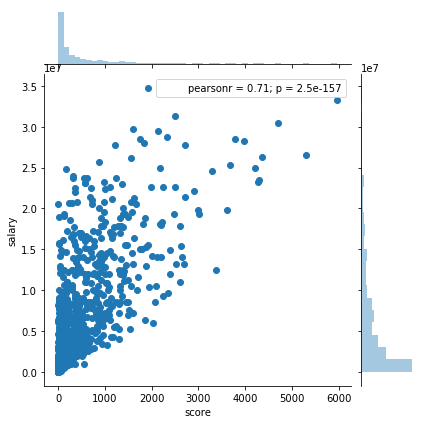

In [46]:
sns.jointplot(players_df['score'], players_df['salary'], kind='scatter')